# Hands on : introduction to NN on HEP dataset

### Many thanks to _Rafael Coelho Lopes De Sa, Fernando Torales Acosta, David Rousseau, Yann Coadou_, and _Aishik Gosh_, and others for help with this!

## Import Packages

[This should look familiar!]

In [1]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import uproot as ur

import jax

from IPython.display import display, HTML
%matplotlib inline
import time
pd.set_option('display.max_columns', None) # to see all columns of df.head()
np.random.seed(31415) # set the random seed for the reproducibility

In [2]:
print(jax.__version__)

0.4.28


JAX can use GPU's automatically (almost no change to code below). However, for this tutorial we will just use the CPU!

# Load events

The data was created from ATLAS Open Data. Lets load it in! Jim's lectures will show us more of these details. We have a simple function that will load and clean up the data a bit. It will return it in a `pandas.DataFrame`.

* Feel free to inspect what it does in the `extra_function.py` file!

In [3]:
from extra_functions import load_training_file
all_data = load_training_file()

And a quick look at a few things, so we can see what we are looking at.

In [4]:
f"{len(all_data):,}"

'577,357'

In [5]:
all_data.columns

Index(['index', 'eventNumber', 'label', 'met_et', 'met_phi', 'lep_n',
       'lep_pt_0', 'lep_pt_1', 'lep_eta_0', 'lep_eta_1', 'lep_phi_0',
       'lep_phi_1', 'lep_E_0', 'lep_E_1', 'lep_charge_0', 'lep_charge_1',
       'lep_type_0', 'lep_type_1', 'jet_n', 'jet_pt_0', 'jet_pt_1',
       'jet_eta_0', 'jet_eta_1', 'jet_phi_0', 'jet_phi_1', 'jet_E_0',
       'jet_E_1', 'mcWeight', 'runNumber', 'channelNumber'],
      dtype='object')

Note we have lep 0 and 1, and jet 0 and jet 1. But they are unrolled (not, as you will learn, an `awkward` array).

The `label` column tells us if it is signal (`1`) or background (`0`). And we can make some plots. You'll learn more about plotting later in the week.

One more very important prep step is to *shuffle* the data before we use it.

* If you train on sub-samples this assures there is a good mix.
* Files are often built by putting signal first and background second - meaning all the events some in order.

In [6]:
all_data = all_data.sample(frac=1).reset_index(drop=True)

Now - lets look at the data and see, visually, how it looks. You'll learn later this week how to use `matplotlib` - the code below is very crude, but it looks at all the variables!

<Figure size 640x480 with 0 Axes>

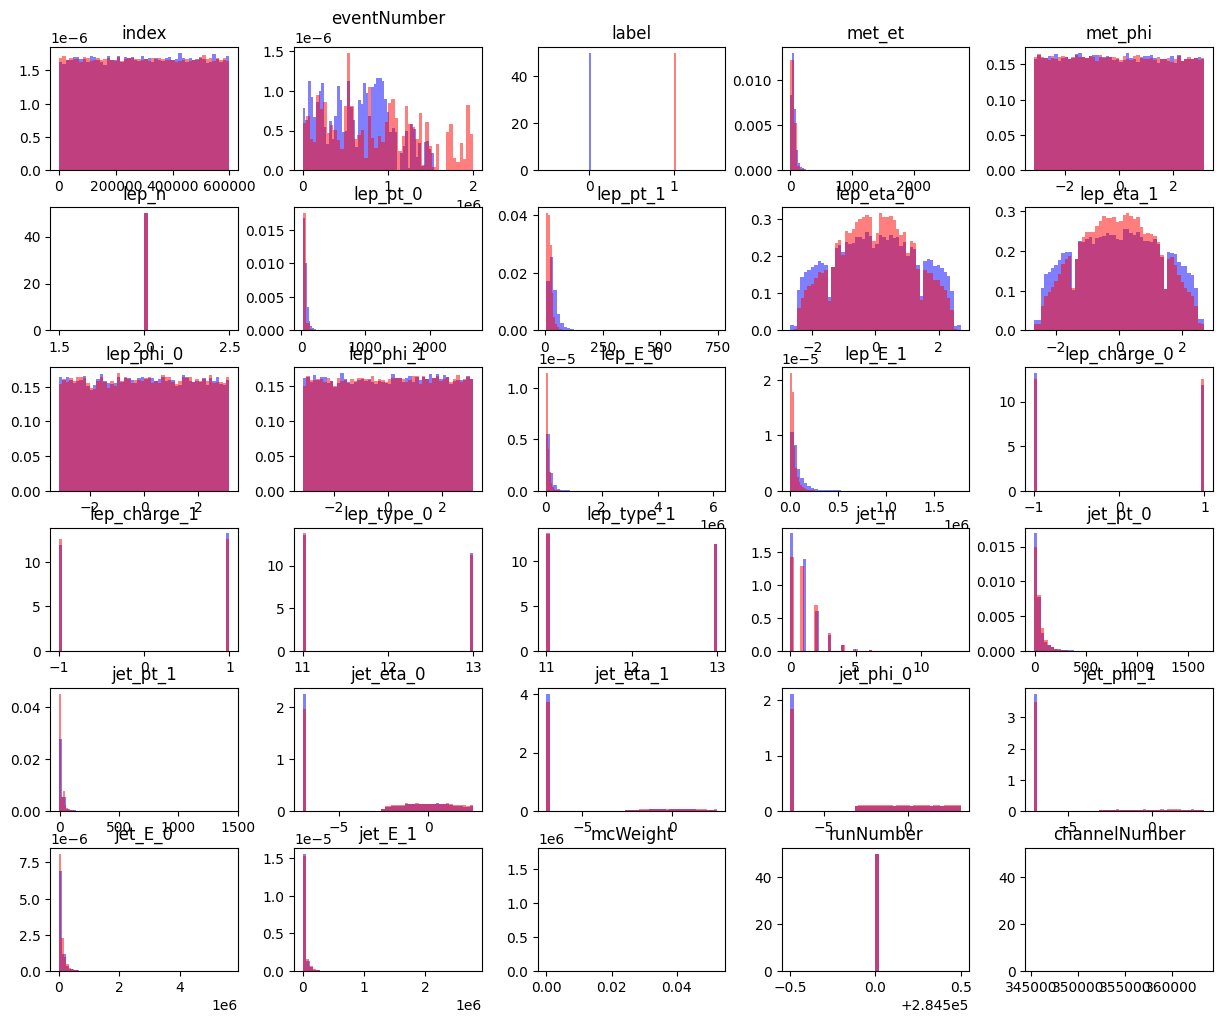

In [31]:
plt.figure()

ax=all_data[all_data.label==0].hist(weights=all_data.mcWeight[all_data.label==0],figsize=(15,12),color='b',alpha=0.5,density=True,bins=50,grid=False)
ax=ax.flatten()[:all_data.shape[1]] # to avoid error if holes in the grid of plots (like if 7 or 8 features)
all_data[all_data.label==1].hist(weights=all_data.mcWeight[all_data.label==1],figsize=(15,12),color='r',alpha=0.5,density=True,ax=ax,bins=50,grid=False)

plt.show()

Clearly, there are a number of items that should not be used for training. Like `runNumber` or `label` (which is ground truth for the training!!!). Also note that the phi's aren't that different (as expected due to the symmetry of the beamline/detector) So, lets start with a safe set. You can come back later and modify this list if you want!

In [8]:
columns_to_train_on = ["met_et","met_phi","lep_pt_0","lep_pt_1",'lep_phi_0', 'lep_phi_1']
data=pd.DataFrame(all_data, columns=columns_to_train_on)

#### Feature engineering

Besides adding in variables like above, we can also create new variables using our physics knowledge. For example, we know that the open angle between the two leptons can be a good discriminator. The NN might be able to learn this - but since we know, we might as well help it out.

We'll leave this protected for now so that you can come back and try this out later.

In [9]:
use_delta_phi = False
if use_delta_phi: 
    data["lep_deltaphi"]=np.abs(np.mod(data.lep_phi_1-data.lep_phi_0+3*np.pi,2*np.pi)-np.pi)

In [10]:
data.head()

,met_et,met_phi,lep_pt_0,lep_pt_1,lep_phi_0,lep_phi_1
0,54.141,1.56370,61.090,26.759,3.03010,-2.52210
1,56.874,2.35970,39.935,32.258,1.22300,-1.28580
2,42.962,-0.75914,56.305,31.369,2.56600,2.36850
3,143.950,0.29326,50.835,13.572,-0.26881,-1.79850
4,70.482,-2.70940,36.437,23.880,0.18903,0.35253


# Preparing the data for training.

First we need to split the data into test and training samples. `scikit-learn` has some great utilities that make this a breeze.

First thing to consider - what fraction do we want to use for training vs testing? Make this a small number to speed training (e.g. small number of samples to train on) and a larger number for more accurate training.

In [11]:
train_size = 0.1

Traditionally `X` is the data we train on, `Y` is _ground truth_ - what we are aiming for, and `weights` are per event weights (usually from MC).

We also split things into `test` and `train` for testing and training. The training sample will be biased by the training, of course, so we keep the `test` sample independent.

In [12]:
X = data
y = all_data.label
weights = all_data.mcWeight

print(f"X shape: {X.shape}, Y shape: {y.shape}, weights shape: {weights.shape}")

X shape: (577357, 6), Y shape: (577357,), weights shape: (577357,)


Make sure that everything is the same length! If not, very bad things will happen below!

Ok - next we can use a very useful library routine, `train_test_split` to split everything up:

In [13]:
from sklearn.model_selection import train_test_split


X_train, X_test, y_train, y_test, weights_train, weights_test = train_test_split(
    X, y, weights, train_size=train_size
)

# Following just gets around some issues with how pandas works.
y_train = y_train.reset_index(drop=True)
y_test = y_test.reset_index(drop=True)
X_train = X_train.reset_index(drop=True)
X_test = X_test.reset_index(drop=True)
weights_train = weights_train.reset_index(drop=True)
weights_test = weights_test.reset_index(drop=True)

print("Xtrain Shape: ", X_train.shape)
print("ytrain Shape: ", y_train.shape)
print("Training Weights: ", weights_train.shape, "\n")
print("Xtest Shape: ", X_test.shape)
print("ytest Shape: ", y_test.shape)
print("Test Weights: ", weights_test.shape)

Xtrain Shape:  (57735, 6)
ytrain Shape:  (57735,)
Training Weights:  (57735,) 

Xtest Shape:  (519622, 6)
ytest Shape:  (519622,)
Test Weights:  (519622,)


Often, when doing a real ML training, you'll want to split the test dataset in half - for a test and validation datasets:

- __Training Dataset:__ The sample of data used to fit the model.
- __Validation Dataset:__ The sample used to provide an unbiased evaluation of a model fit on the training dataset while tuning  hyperparameters.
- __Test Dataset:__ The sample of data used to provide an unbiased evaluation of a final model fit on the training dataset.

Why are we so worried about bias?

## Converting to the JAX data arrays

JAX has its own data array types. This is because it wants to be able to work on both your CPU and your GPU - or even remotely. As a result it has a concept of a `DeviceArray` - something `numpy` does not need.

In [14]:
import jax.numpy as jnp

X_train = jnp.array(X_train)
X_test = jnp.array(X_test)
y_train = jnp.array(y_train)
y_test = jnp.array(y_test)
weights_train = jnp.array(weights_train)
weights_test = jnp.array(weights_test)

# Building a JAX Neural Network

First, lets build the JAX NN as we have done in previous efforts. Think a little bit about what we want the output to look like - we want it to be a zero if it is background and a 1 if it is signal. It should never go beyond that.

In [15]:
import jax
import jax.numpy as jnp
import jax.nn
import haiku as hk
from optax import adam, apply_updates

def net_fn(x):
    mlp = hk.Sequential([
        hk.Linear(12), jax.nn.relu,
        hk.Linear(60), jax.nn.relu,
        hk.Linear(32), jax.nn.relu,
        hk.Linear(1), jax.nn.sigmoid
    ])
    return mlp(x)

net = hk.transform(net_fn)

Next, randomly initalize the parameters we'll be training on.

In [16]:
rng = jax.random.PRNGKey(42)
params = net.init(rng, jnp.ones((1, X_train.shape[1])))

The optimizer we'll use - default to `adam`.

In [17]:
optimizer = adam(0.001)

And the loss function. Lets use the same one we did before.

In [18]:
@jax.jit
def loss(params, rng, x, y):
    preds = net.apply(params, rng, x)
    return jnp.mean((preds - y) ** 2)

Finally, the update function that will generate an update of the code. Note that we should JIT the `update` function to speed it up.

In [19]:
f_gradient = jax.grad(loss)

@jax.jit
def update(params, rng, opt_state, x, y):
    grads = f_gradient(params, rng, x, y)
    updates, opt_state = optimizer.update(grads, opt_state)
    return apply_updates(params, updates), opt_state

## Training Loop

As before lets initialize the state as ready to go. We will also track the losses each step so we can see how they are going.

In [20]:
opt_state = optimizer.init(params)

losses_training = []
losses_test = []

# How much of the training sample to calculate the loss on.
# Keep it large enough to be meaningful, but small enough to be fast.
n_loss = 10000

The training loop, finally! Note that we've designed this so that we can keep re-running it... so if the first 10 aren't enough, we can just re-run the loop.

In [22]:
starting_time = time.time()

print("starting training...")

if len(losses_training) == 0:
    # Prime the loss arrays.
    losses_training.append(loss(params, rng, X_train[:n_loss], y_train[:n_loss]))
    losses_test.append(loss(params, rng, X_test[:n_loss], y_test[:n_loss]))

for epoch in range(10):
    print(f"training {epoch}: {losses_training[-1]:0.4}")
    params, opt_state = update(params, rng, opt_state, X_train, y_train)
    losses_training.append(loss(params, rng, X_train[:n_loss], y_train[:n_loss]))
    losses_test.append(loss(params, rng, X_test[:n_loss], y_test[:n_loss]))

print("done training...")

training_time = time.time() - starting_time
print("Training time:", training_time)

starting training...
training 0: 0.2404
training 1: 0.2436
training 2: 0.2416
training 3: 0.2348
training 4: 0.2292
training 5: 0.2283
training 6: 0.2291
training 7: 0.2287
training 8: 0.2267
training 9: 0.2243
done training...
Training time: 23.312483072280884


Note how long this took compared to the BDT training!

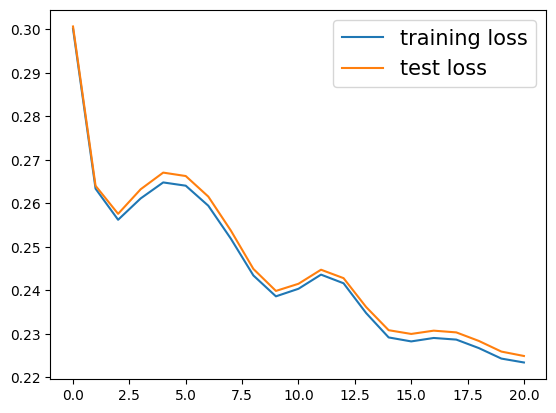

In [23]:
plt.plot(losses_training,label="training loss")
plt.plot(losses_test,label="test loss")

plt.legend(fontsize=15)
plt.show()

## Evaluating the Training

Evaluate the model based on predictions made with X_test $\rightarrow$ y_test

In [24]:
y_pred_test = net.apply(params, rng, X_test)
y_pred_train = net.apply(params, rng, X_train)

### ROC curves and Area Under the Curve (AUC)

In [25]:
from sklearn.metrics import roc_auc_score # for binary classification if x > 0.5 -> 1 else -> 0
from sklearn.utils import class_weight # to set class_weight="balanced"

Text(0.5, 1.0, 'Receiver Operating Characteristic')

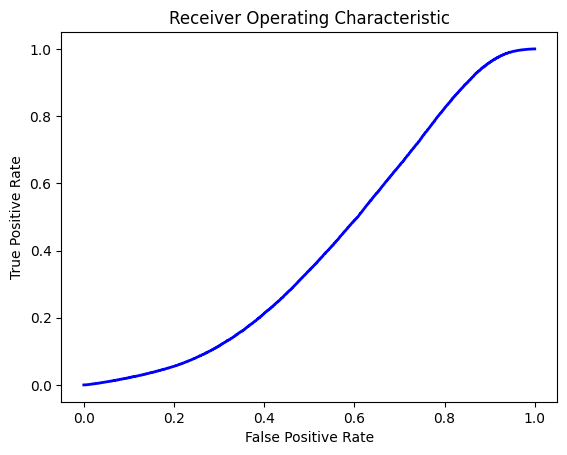

In [26]:
from sklearn.metrics import roc_curve
fpr,tpr,_ = roc_curve(y_true=y_test, y_score=y_pred_test,sample_weight=weights_test)
plt.plot(fpr, tpr, color='blue',lw=2)
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic')

In [28]:
auc_test = roc_auc_score(y_true=y_test, y_score=y_pred_test,sample_weight=weights_test)
auc_train = roc_auc_score(y_true=y_train, y_score=y_pred_train,sample_weight=weights_train)
print("auc test:",auc_test)
print ("auc train:",auc_train)

auc test: 0.41730858465327414
auc train: 0.42202442618959074


### Plotting NN Score for Signal and Background

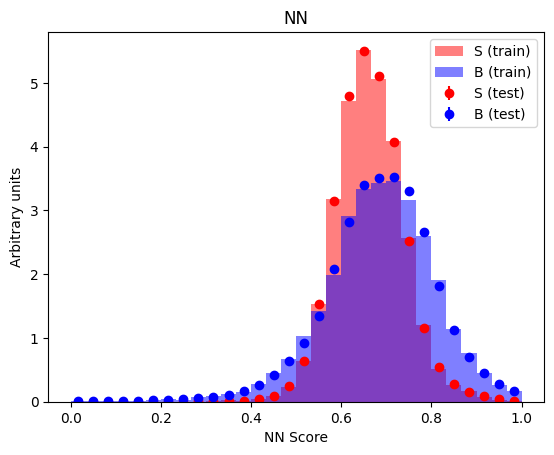

In [29]:
from extra_functions import compare_train_test
compare_train_test(y_pred_train.reshape(-1), y_train, y_pred_test.reshape(-1), y_test, 
                   xlabel="NN Score", title="NN", 
                   weights_train=weights_train, weights_test=weights_test)